In [1]:
import Pkg
Pkg.activate(temp=true)
Pkg.add(name="DataFlowTasks", rev="main")
Pkg.add("BenchmarkTools")
using DataFlowTasks, BenchmarkTools, Random

DataFlowTasks.stack_weakdeps_env!()
using GraphViz, CairoMakie

  Activating new project at `/tmp/jl_QNBOjA`
    Updating git-repo `https://github.com/maltezfaria/DataFlowTasks.jl.git`
   Resolving package versions...
    Updating `/tmp/jl_QNBOjA/Project.toml`
  [d1549cb6] + DataFlowTasks v0.1.0 `https://github.com/maltezfaria/DataFlowTasks.jl.git#main`
    Updating `/tmp/jl_QNBOjA/Manifest.toml`
  [34da2185] + Compat v4.10.0
  [d1549cb6] + DataFlowTasks v0.1.0 `https://github.com/maltezfaria/DataFlowTasks.jl.git#main`
  [bac558e1] + OrderedCollections v1.6.2
  [6c6a2e73] + Scratch v1.2.1
  [0dad84c5] + ArgTools v1.1.1
  [56f22d72] + Artifacts
  [2a0f44e3] + Base64
  [ade2ca70] + Dates
  [f43a241f] + Downloads v1.6.0
  [7b1f6079] + FileWatching
  [b77e0a4c] + InteractiveUtils
  [b27032c2] + LibCURL v0.6.4
  [76f85450] + LibGit2
  [8f399da3] + Libdl
  [37e2e46d] + LinearAlgebra
  [56ddb016] + Logging
  [d6f4376e] + Markdown
  [ca575930] + NetworkOptions v1.2.0
  [44cfe95a] + Pkg v1.10.0
  [de0858da] + Printf
  [3fa0cd96] + REPL
  [9a3f8284] + Random

Status `~/.julia/scratchspaces/d1549cb6-e9f4-42f8-98cc-ffc8d067ff5b/weakdeps-1.10/Project.toml`
⌃ [13f3f980] CairoMakie v0.10.11
⌃ [e9467ef8] GLMakie v0.8.11
  [f526b714] GraphViz v0.2.0
⌅ [ee78f7c6] Makie v0.19.11
Info Packages marked with ⌃ and ⌅ have new versions available. Those with ⌃ may be upgradable, but those with ⌅ are restricted by compatibility constraints from upgrading. To see why use `status --outdated`


[ Info: Loading DataFlowTasks dag plot utilities
[ Info: Loading DataFlowTasks general plot utilities


# Demo: parallel merge sort

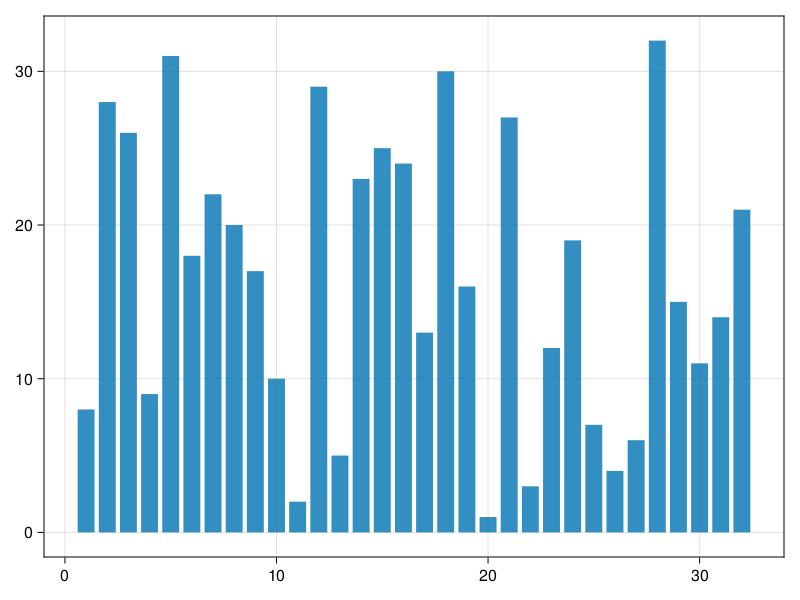

In [2]:
using Random, CairoMakie

v = randperm(32)
barplot(v)

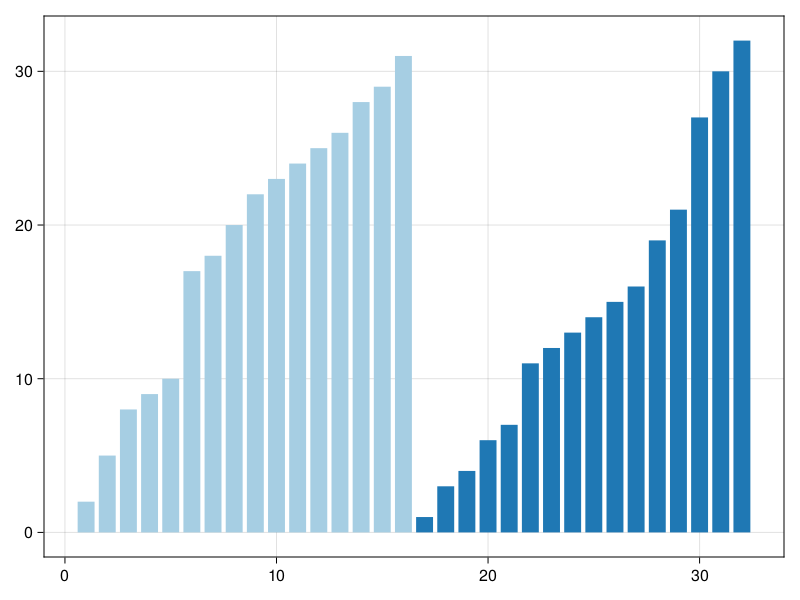

In [3]:
@views sort!(v[1:16])
@views sort!(v[17:32])

barplot(v; color=ceil.(Int, eachindex(v)./16), colormap=:Paired_4, colorrange=(1,4))

In [4]:
function merge!(dest, left, right)
    (i, j) = (1, 1)
    (I, J) = (length(left), length(right))
    @assert I + J == length(dest)
    @inbounds for k in eachindex(dest)
        if i <= I && (j > J || left[i] < right[j])
            dest[k] = left[i]; i += 1
        else
            dest[k] = right[j]; j+=1
        end
    end
end

merge! (generic function with 1 method)

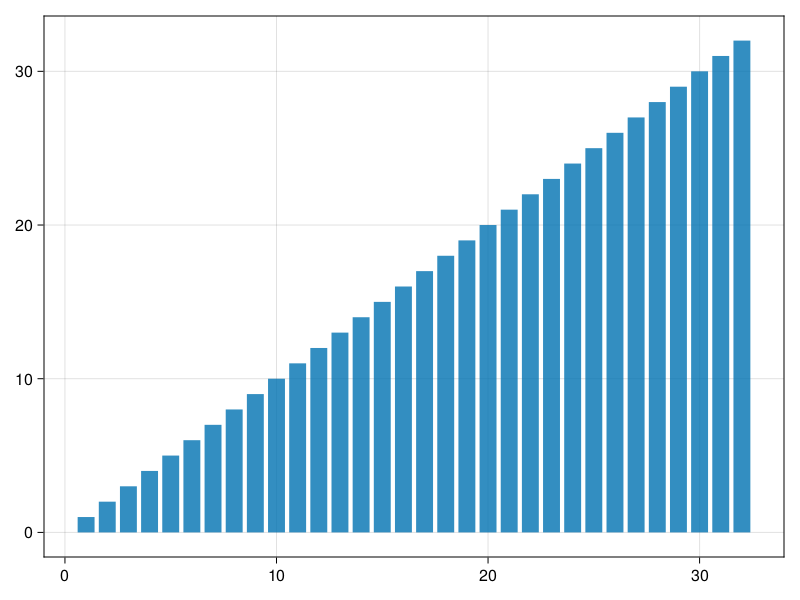

In [5]:
buf = similar(v)
@views merge!(buf, v[1:16], v[17:32])
barplot(buf)

In [6]:
function merge_sort!(vec, buf=similar(vec))
    N = length(vec)
    if N < 64
        sort!(vec, alg=InsertionSort)
        return vec
    end

    mid = N ÷ 2

    @assert length(buf) == N
    left  = @view vec[begin:mid]; left_buf  = @view buf[begin:mid]
    right = @view vec[mid+1:end]; right_buf = @view buf[mid+1:end]

    merge_sort!(left,  left_buf)
    merge_sort!(right, right_buf)

    merge!(buf, left, right)
    copyto!(vec, buf)
end


merge_sort! (generic function with 2 methods)

In [7]:
using BenchmarkTools

N = 100_000
v = rand(N); buf = similar(v)

@assert issorted(merge_sort!(copy(v)))
bench_seq = @benchmark merge_sort!(w, $buf) setup=(w=copy(v)) evals=1

BenchmarkTools.Trial: 762 samples with 1 evaluation.
 Range (min … max):  6.407 ms …   7.220 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     6.447 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   6.507 ms ± 123.056 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▃▇██▅▄▄▃▂▃▁▁▁▁ ▁ ▁▂ ▁    ▁                                   
  ███████████████████▆██▇▇▆██▇█▆▅▇█▅██▇█▇▆▇▇▅▆▅▇▄▇▁▄▆▄▆▅▅▄▁▁▅ █
  6.41 ms      Histogram: log(frequency) by time      6.91 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [8]:
using DataFlowTasks

function merge_sort_dft_async!(vec, buf=similar(vec))
    N = length(vec)
    if N < 8192
        return @dspawn merge_sort!(@RW(vec), @W(buf)) label="sort\n$N"
    end

    @assert length(buf) >= N
    
    mid = N ÷ 2

    left  = @view vec[begin:mid]; left_buf  = @view buf[begin:mid]
    right = @view vec[mid+1:end]; right_buf = @view buf[mid+1:end]
    merge_sort_dft_async!(left,  left_buf)
    merge_sort_dft_async!(right, right_buf)

    @dspawn merge!(@W(buf), @R(left), @R(right)) label="merge\n$N"
    @dspawn copyto!(@W(vec), @R(buf)) label="copy\n$N"
end

merge_sort_dft!(vec, buf=similar(vec)) = fetch(merge_sort_dft_async!(vec, buf))

merge_sort_dft! (generic function with 2 methods)

In [9]:
@assert issorted(merge_sort_dft!(copy(v)))
bench_dft = @benchmark merge_sort_dft!(w, $buf) setup=(w=copy(v)) evals=1

BenchmarkTools.Trial: 1853 samples with 1 evaluation.
 Range (min … max):  2.223 ms …   6.724 ms  ┊ GC (min … max): 0.00% … 55.44%
 Time  (median):     2.568 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.604 ms ± 233.758 μs  ┊ GC (mean ± σ):  0.20% ±  2.17%

           ▄▃▃▅▃▆▂▇▇█▃▅▆▇▃▂▁▃▂ ▃▃▂▂▁   ▁                       
  ▁▁▂▃▅▄▇▆▇███████████████████████████▆█▆▆▆▇▄▆▅▄▅▅▄▃▂▃▁▁▂▂▁▂▂ ▅
  2.22 ms         Histogram: frequency by time        3.11 ms <

 Memory estimate: 401.34 KiB, allocs estimate: 5174.

In [10]:
(; nthreads = Threads.nthreads(),
speedup = minimum(bench_seq).time / minimum(bench_dft).time)

(nthreads = 4, speedup = 2.8824976707379455)

In [11]:
log_info = DataFlowTasks.@log merge_sort_dft!(copy(v))

LogInfo with 46 logged tasks


In [12]:
categories = ["sort", "merge", "copy"]
DataFlowTasks.describe(log_info; categories)

• Elapsed time           : 0.003
  ├─ Critical Path       : 0.001
  ╰─ No-Wait             : 0.002

• Run time               : 0.011
  ├─ Computing           :   0.007
  │  ├─ sort             :     0.005
  │  ├─ merge            :     0.002
  │  ├─ copy             :     0.000
  │  ╰─ unlabeled        :     0.000
  ├─ Task Insertion      :   0.000
  ╰─ Other (idle)        :   0.003


In [13]:
using GraphViz
g = GraphViz.Graph(log_info)
DataFlowTasks.savedag("dag.svg", g)

using Markdown
md"![](dag.svg)"

![](dag.svg)


[ Info: Computing    : 0.007499715000000001
[ Info: Inserting    : 0.00017239300000000001
[ Info: Other        : 0.003245424024905089


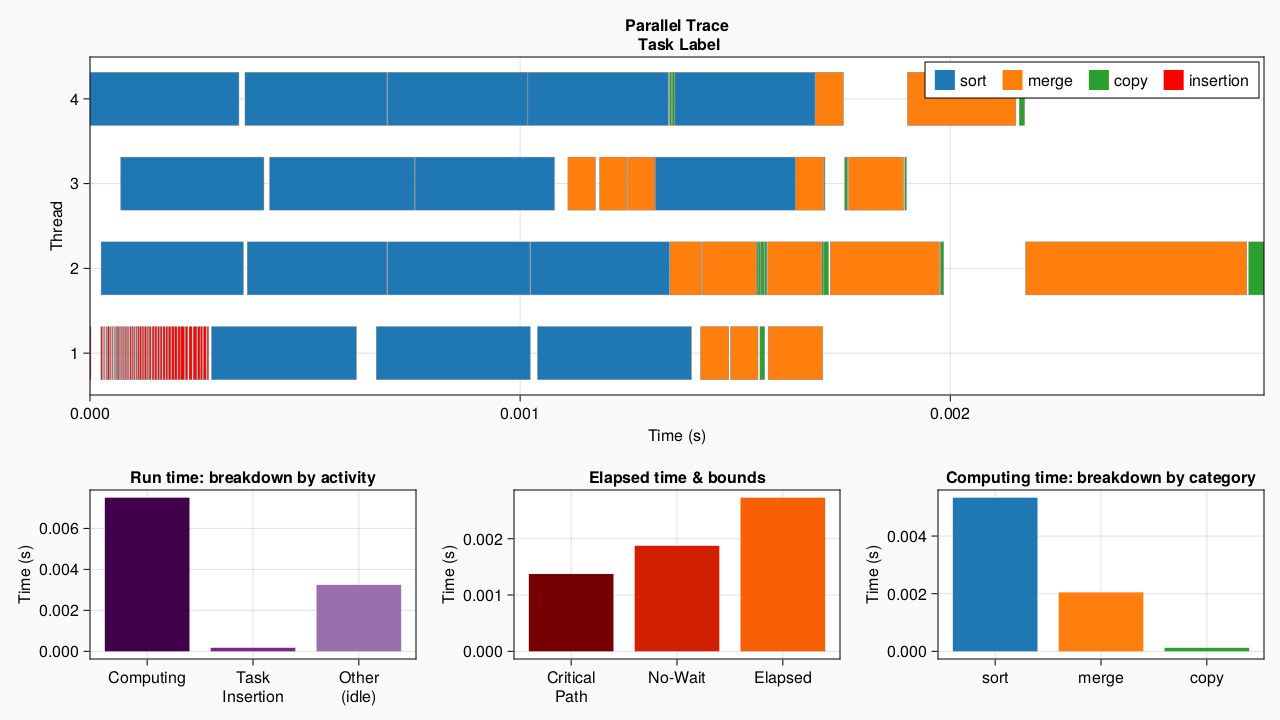

In [14]:
using CairoMakie
plot(log_info; categories)